In [ ]:
!pip install tensorflow==2.16.2
!pip install --upgrade boto3

**IMPORTS**

In [27]:
import tensorflow as tf
# Changes AWS to True if on SageMaker Instance and set S3 BUCKET and Key accordingly
AWS = False
REGION = 'eu-west-1'
BUCKET = 'ml-can-ids-logs'
s3 = None

# Import Functions
import setuptools.dist

from importlib import reload
import utils
import anomaly_detection_functions
import clustering
import feature_selection
import train
import id_embedding

reload(utils)
reload(train)
reload(anomaly_detection_functions)
reload(clustering)
reload(feature_selection)
reload(id_embedding)

from utils import plot_loss_curve, plot_pca, plot_tsne, get_confusion_matrix, get_latent_representations_label, analyze_latent_variance, analyze_kl_divergence, linear_annealing, save_results_to_excel, save_trained_model, get_s3_client, check_dataset
from anomaly_detection_functions import get_threshold_from_train, get_threshold_from_test, anomaly_detection, get_anomaly_detection_accuracy, get_mean_variances
from clustering import visualize_anomalies, evaluate_anomaly_detector, detect_anomalies_one_class_svm_with_threshold, train_hdbscan_detector, evaluate_hdbscan_detector, detect_anomalies_hdbscan, hdbscan_set_threshold, visualize_results
from clustering import prepare_features, train_isolation_forest, train_one_class_svm, detect_anomalies_isolation_forest, detect_anomalies_one_class_svm, evaluate_anomaly_detector_verbose
from feature_selection import feature_selection_preparation, convert_to_tensorflow, feature_selection_preparation_new
from train import train_model, train_model_factor , train_model_btc, train_model_bernoulli, train_model_semi
from id_embedding import train_embedding

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Model
import itertools
import pandas as pd
from datetime import datetime
import warnings
import keras
from scipy.stats import entropy
import scipy.stats
from tensorflow.keras.optimizers.schedules import CosineDecay
from importlib import reload
import gc
import tensorflow.keras.backend as K

if AWS:
    import boto3
    from io import StringIO

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)

# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU")
    device = "/GPU:0"
else:
    print("❌ Using CPU")
    device = "/CPU:0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 0
❌ Using CPU


------------------------------------------------------------------

**PATH FILES**

In [28]:
if AWS:
    s3 = get_s3_client(REGION, BUCKET, True)
    
    # Get S3 Object 
    channel2logs = s3.get_object(Bucket = BUCKET, Key= 'channel2Logs.csv')
    dos_attack_channel2 = s3.get_object(Bucket = BUCKET, Key= 'dos_attack_channel2.csv')
    replay_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'replay_attack_channel2.csv') 
    spoofing_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'new_spoofing_attack_channel2.csv') 

    channel2logs = channel2logs['Body'].read().decode('utf-8')
    dos_attack_channel2 = dos_attack_channel2['Body'].read().decode('utf-8')
    replay_attack_channel2 = replay_attack_channel2['Body'].read().decode('utf-8')
    spoofing_attack_channel2 = spoofing_attack_channel2['Body'].read().decode('utf-8')

    # Get Content
    channel2logs = StringIO(channel2logs)
    dos_attack_channel2 = StringIO(dos_attack_channel2)
    replay_attack_channel2 = StringIO(replay_attack_channel2)
    spoofing_attack_channel2 = StringIO(spoofing_attack_channel2)

    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = dos_attack_channel2 # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = replay_attack_channel2 # Replay on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = spoofing_attack_channel2 # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel2_csv_path = channel2logs # Red Channel
    preprocessed_normal_channel4_csv_path = "" # Yellow Channel
    preprocessed_normal_channel5_csv_path = "" # Green Channel

    # Current best model
    best_model_path = ""
else:
    # Unprocessed Normal and Attack Data
    preprocessed_normal_csv_path = './Dataset/Tw22206_L003_with_ecu_channel.csv'  # Normal Unprocessed
    preprocessed_DoS_csv_path = './Dataset/Attack_Logs/dos_attack.csv'  # Dos Unprocessed
    preprocessed_Fuzzy_csv_path = './Dataset/Attack_Logs/fuzzy_attack.csv'  # Fuzzy Unprocessed
    preprocessed_Replay_csv_path = './Dataset/Attack_Logs/replay_attack.csv'  # Replay Unprocessed - Test
    preprocessed_Spoofing_csv_path = './Dataset/Attack_Logs/spoofing_attack.csv'  # Spoofing Unprocessed
    preprocessed_Suspension_csv_path = './Dataset/Attack_Logs/suspension_attack.csv'  # Suspension Unprocessed - Hardest Attack Type


    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = './Dataset/Attack_Logs/dos_attack_channel2.csv'  # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = './Dataset/Attack_Logs/replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_new_Replay_channel2_csv_path = './Dataset/Attack_Logs/new_replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_Suspension_channel2_csv_path = './Dataset/Attack_Logs/suspension_attack_channel2.csv'  # Suspension on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_new_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/new_spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)

    preprocessed_50K_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_50K_33s_56s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_200K_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_200K_33s_169s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_1000k_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_1000K_33s_776s.csv'  # Replay on channel 2 (Red Channel)

    preprocessed_50K_Replay_channel2_part1_csv_path = './Dataset/Attack_Logs/Train_Replay_Attack_Channel2_50K_33s_56s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_200K_Replay_channel2_part1_csv_path = './Dataset/Attack_Logs/Train_Replay_Attack_Channel2_200K_33s_169s.csv'  # Replay on channel 2 (Red Channel)

    preprocessed_50K_Replay_channel2_part2_csv_path = './Dataset/Attack_Logs/Test_Replay_Attack_Channel2_50K_33s_56s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_200K_Replay_channel2_part2_csv_path = './Dataset/Attack_Logs/Test_Replay_Attack_Channel2_200K_33s_169s.csv'  # Replay on channel 2 (Red Channel)


    preprocessed_50K_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_50K_33s_56s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_200K_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_200K_33s_169s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_1000k_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_1000K_33s_775s.csv'  # Spoofing on channel 2 (Red Channel)

    preprocessed_50K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K__Spoofing_Attack_Channel2_50K_33s_56s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_200K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K_Spoofing_Attack_Channel2_200K_33s_169s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_1000K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K_Spoofing_Attack_Channel2_1000K_33s_776s.csv'  # Spoofing on channel 2 (Red Channel)


    # Open Source Datasets:
     
    # Car Hacking
    HCRL_CarHacking_Normal_csv_path = './Dataset/HCRL_CarHacking/Normal_dataset.csv' 
    HCRL_CarHacking_DoS_csv_path = './Dataset/HCRL_CarHacking/DoS_fixed_dataset.csv' 
    HCRL_CarHacking_Fuzzy_csv_path = './Dataset/HCRL_CarHacking/Fuzzy_fixed_dataset.csv' 
    HCRL_CarHacking_Spoofing_Gear_csv_path = './Dataset/HCRL_CarHacking/Gear_fixed_dataset.csv' 
    HCRL_CarHacking_Spoofing_RPM_csv_path = './Dataset/HCRL_CarHacking/RPM_fixed_dataset.csv' 

    # OTIDS
    HCRL_OTIDS_Normal_csv_path = './Dataset/HCRL_OTIDS/Normal_dataset.csv' 
    HCRL_OTIDS_DoS_csv_path = './Dataset/HCRL_OTIDS/DoS_dataset.csv' 
    HCRL_OTIDS_Fuzzy_channel2_csv_path = './Dataset/HCRL_OTIDS/Fuzzy_dataset.csv' 
    HCRL_OTIDS_Impersonation_channel2_csv_path = './Dataset/HCRL_OTIDS/Impersonation_dataset.csv' 

    # Competition
    HCRL_Competition_Pre_S_Train_1_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_S_0' 
    HCRL_Competition_Pre_S_Train_2_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_S_1' 
    HCRL_Competition_Pre_S_Train_3_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_S_2' 

    HCRL_Competition_Pre_D_Train_1_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_D_0'
    HCRL_Competition_Pre_D_Train_2_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_D_1'
    HCRL_Competition_Pre_D_Train_3_csv_path = './Dataset/HCRL_Competition/0_Preliminary/0_Training/Pre_train_D_2'

    HCRL_Competition_Pre_S_Submission_3_csv_path = './Dataset/HCRL_Competition/0_Preliminary/1_Submission/Pre_submit_S' 
    HCRL_Competition_Pre_D_Submission_1_csv_path = './Dataset/HCRL_Competition/0_Preliminary/1_Submission/Pre_submit_D'

    HCRL_Competition_Final_S_Submission_1_csv_path = './Dataset/HCRL_Competition/0_Preliminary/1_Final/Fin_host_session_submit_S'



    # Unprocessed Channel Data
    preprocessed_normal_channel0_csv_path = './Dataset/Channel_Logs/channel0Logs.csv'  
    preprocessed_normal_channel2_csv_path = './Dataset/Channel_Logs/channel2Logs.csv'  # Red Channel
    preprocessed_normal_channel4_csv_path = './Dataset/Channel_Logs/channel4Logs.csv'  # Yellow Channel
    preprocessed_normal_channel5_csv_path = './Dataset/Channel_Logs/channel5Logs.csv'  # Green Channel


    # Preprocessed Dataframe Data
    processeddataframe_normal_csv_path = './Dataset/Processed_Dataframes/train_dataframe.csv'  # Normal CSV Dataframe (Turns Lists into Strings)
    processeddataframe_DoS_csv_path = './Dataset/Processed_Dataframes/test_DoS_dataframe.csv'  # DoS CSV Dataframe (Turns Lists into Strings)

    # Preprocessed Pickle Data
    processeddataframe_normal_pickle_path = './Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl'  # Normal Pickle Dataframe
    processeddataframe_DoS_pickle_path = './Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl'  # DoS Pickle Dataframe

    # Current best model
    best_model_path = "./Resources/Models/SOA_VAE_E6_LD38_EP30_NT100000_B1024_I42.keras"



    # PRELOAD Dataframe for Debug
    DEBUG = False 


---------------------------------------------

In [ ]:
reload(utils)
reload(feature_selection)
LOAD_DATAFRAME = False
BINARY = False
BINARY_ID = False

n_rows_train = 50000  # select how many rows to load. None if whole train datasset
n_rows_test = 50000   # select how many rows to load. None if whole test datasset
batch_size = 1024 
window_size = 50    # increase window size
stride = 25     # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly = 5  # For 1 anomaly per window do: 1 / window_size

if LOAD_DATAFRAME:
    # Load training data
    processeddataframe = pd.read_pickle(processeddataframe_normal_pickle_path)
    train_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size)

    # Load test data
    processeddataframe_test = pd.read_pickle(processeddataframe_DoS_pickle_path)
    test_dataset = convert_to_tensorflow(processeddataframe_test['features'] ,processeddataframe_test['type'], batch_size= batch_size )
else:
    
    # Preprocess and load training data
    processeddataframe , embedding_model, id_to_embedding, scalers = feature_selection_preparation(HCRL_CarHacking_Normal_csv_path, phase = 'training', rows=n_rows_train, binary = BINARY, binary_id= BINARY_ID)
    train_dataset, val_dataset, val_dataset2 = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)

    #processeddataframe_test = feature_selection_preparation(HCRL_CarHacking_DoS_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    #test_dataset_dos_hcrl, test_threshold_dataset_dos_hcrl = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    processeddataframe_test = feature_selection_preparation(HCRL_CarHacking_DoS_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    test_dataset_dos_hcrl, test_threshold_dataset_dos_hcrl = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)
    
    #processeddataframe_test = feature_selection_preparation(HCRL_CarHacking_Fuzzy_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    #test_dataset_fuzzy, test_threshold_dataset_fuzzy = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    #processeddataframe_test = feature_selection_preparation(HCRL_CarHacking_Spoofing_Gear_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    #test_dataset_spoofing_gear, test_threshold_dataset_spoofing_gear = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    #processeddataframe_test = feature_selection_preparation(HCRL_CarHacking_Spoofing_RPM_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    #test_dataset_spoofing_RPM, test_threshold_dataset_spoofing_RPM = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)
    """

    processeddataframe , embedding_model, id_to_embedding, scalers = feature_selection_preparation_new(preprocessed_50K_Replay_channel2_part1_csv_path, phase = 'test', rows=n_rows_train, binary = BINARY, binary_id= BINARY_ID, train_embedding_scaler = True)
    train_dataset, val_dataset = convert_to_tensorflow(processeddataframe['features'], processeddataframe['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    processeddataframe_test = feature_selection_preparation_new(preprocessed_50K_Replay_channel2_part2_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers, train_embedding_scaler = False)
    test_dataset, test_threshold_dataset = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    processeddataframe_normal = feature_selection_preparation_new(preprocessed_normal_channel2_csv_path, phase = 'training', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers, train_embedding_scaler = False)
    train_dataset_normal, val_dataset_normal, val_dataset2_normal = convert_to_tensorflow(processeddataframe_normal['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)
    """

#############START#####################
Amount of unique IDS in training: 25
---Training Embedding Network for Arbitration IDs---
Epoch [0/100], Loss: 1.4411
Epoch [10/100], Loss: 0.7171
Epoch [20/100], Loss: 0.2362
Epoch [30/100], Loss: 0.0733
Epoch [40/100], Loss: 0.0191
Epoch [50/100], Loss: 0.0040
Epoch [60/100], Loss: 0.0024
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
-- ------------------ ---
Average time for ID calculations: 0.000099 seconds
Average time for payload AVERAGE calculations: 0.000041 seconds
Average time for payload CHANGE calculations: 0.000069 seconds
Average time for Entropy per ID calculations: 0.000056 seconds
Compute Temporal Features completed 12.50 seconds
Feature Selection completed in 23.56 seconds
Sliding completed (train) in 0.0110230 seconds
-----------------------------------
Original window that works:  (1876, 50, 19)
Feature shape BEFORE sliding window: (46930, 19)
Feature shape AFTER sliding window: (1876, 

In [ ]:
# todo: check that all values normalized or there's nans in the sliding windows
# todo: check whole processing of df
print(processeddataframe['data'].head(1))
print(processeddataframe['features'].head(4))
print(processeddataframe_test['features'].head(4))
print(np.size(processeddataframe['features'][0]))

processeddataframe['has_nan'] = processeddataframe['features'].apply(lambda x: any(pd.isna(x)) if isinstance(x, list) else np.nan)
valid_lists = [lst for lst in processeddataframe['features'] if isinstance(lst, list)]
all_values = sum(valid_lists, [])
has_nan = any(pd.isna(all_values))
has_out_of_bounds = any(x < 0 or x > 1 for x in all_values if isinstance(x, (int, float)))

print(f"Contains NaN: {has_nan}")
print(f"Contains values <0 or >1: {has_out_of_bounds}")

# Run checks for both datasets
check_dataset(train_dataset, "Train Dataset")
check_dataset(val_dataset, "Validation Dataset")
print(processeddataframe_test.columns)

-----------------------------------------------------------

**VAE SETUP**

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_Mean_Variance_Decoder")
class VAE_Mean_Variance_Decoder(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_Mean_Variance_Decoder, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            #layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])
        # Split into mean and logvar outputs
        self.decoder_mean = layers.TimeDistributed(layers.Dense(input_dim))
        self.decoder_logvar = layers.TimeDistributed(layers.Dense(input_dim))


    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        #print("Z Shape at Decode: " , z.shape)

        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("Z_FLAT Shape at Decode: " , z.shape)
        reconstructed_flat = self.decoder(z_flat)
        # Get mean and logvar
        mean_flat = self.decoder_mean(reconstructed_flat)
        logvar_flat = self.decoder_logvar(reconstructed_flat)
    
        # Reshape back to include samples dimension
        mean = tf.reshape(mean_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        logvar = tf.reshape(logvar_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        
        return mean, logvar

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        
        #reconstructed_mean, reconstructed_logvar = self.decode(z)

        mem_used, (reconstructed_mean, reconstructed_logvar) = measure_memory_usage(self.decode, z)

        #print("Reconstructed Mean: " , reconstructed_mean.shape)
        #print("Reconstructed Logvar: " , reconstructed_logvar.shape)


        return reconstructed_mean, reconstructed_logvar, mu, logvar
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_Mean_Variance_Decoder, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [55]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(64, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(64, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ]) 
        
      
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        #print("AT ENCODE x shape: " , x.shape)
        #print("AT ENCODE hidden shape: ", hidden.shape)
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        #print("AT DECODE: z shape " , z.shape )
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("AT DECODE: z flat shape " , z_flat.shape )

        reconstructed_flat = self.decoder(z_flat)
        #print("AT DECODE: reconstructed flat shape " , reconstructed_flat.shape )

        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        model_outputs = {}
        if latent_only:
            mu, logvar = self.encode(x)
            #mem_used, result = measure_memory_usage(self.encode, x)
            #mu, logvar = result
            model_outputs['encoder_memory'] = 0

            model_outputs['reconstructed'] = None
            model_outputs['mu'] = mu
            model_outputs['logvar'] = logvar
            
            return model_outputs
        mu, logvar = self.encode(x)

        #mem_used, result = measure_memory_usage(self.encode, x)
        #mu, logvar = result
        model_outputs['encoder_memory'] = 0
        #print("AT CALL: mu shape " , mu.shape )
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        #mem_z, z = measure_memory_usage(self.reparameterize, mu, logvar, n_samples=n_samples)

        reconstructed = self.decode(z)
        #print("RECONSTRUCTED shape: ", reconstructed.shape)
        #mem_used, reconstructed = measure_memory_usage(self.decode, z)
        model_outputs['decoder_memory'] = 0
        
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar
        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """

    
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_weak_generator")
class VAE_weakGenerator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_weakGenerator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences= True),
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(50, activation='relu', return_sequences= True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)

        model_outputs = {}
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar

        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_weakGenerator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_2x")
class VAE_2x(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(50, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(50, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)

        model_outputs = {}
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar

        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [44]:
@keras.saving.register_keras_serializable_save(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(64, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(64, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ]) 
        
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        #print("AT ENCODE x shape: " , x.shape)
        #print("AT ENCODE hidden shape: ", hidden.shape)
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        #print("AT DECODE: z shape " , z.shape )
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("AT DECODE: z flat shape " , z_flat.shape )

        reconstructed_flat = self.decoder(z_flat)
        #print("AT DECODE: reconstructed flat shape " , reconstructed_flat.shape )

        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        model_outputs = {}
        if latent_only:
            #mu, logvar = self.encode(x)
            mem_used, result = measure_memory_usage(self.encode, x)
            mu, logvar = result
            model_outputs['encoder_memory'] = mem_used

            model_outputs['reconstructed'] = None
            model_outputs['mu'] = mu
            model_outputs['logvar'] = logvar
            
            return model_outputs
        #mu, logvar = self.encode(x)

        mem_used, result = measure_memory_usage(self.encode, x)
        mu, logvar = result
        model_outputs['encoder_memory'] = mem_used
        #print("AT CALL: mu shape " , mu.shape )
        #z = self.reparameterize(mu, logvar, n_samples=n_samples)
        mem_z, z = measure_memory_usage(self.reparameterize, mu, logvar, n_samples=n_samples)

        #reconstructed = self.decode(z)
        #print("RECONSTRUCTED shape: ", reconstructed.shape)
        mem_used, reconstructed = measure_memory_usage(self.decode, z)
        model_outputs['decoder_memory'] = mem_used + mem_z
        
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar
        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """

    
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        print("Z shape: ", z.shape)
        print("z_mean shape: ", z_mean.shape)
        print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

AttributeError: module 'keras.api.saving' has no attribute 'register_keras_serializable_save'

**Bernoulli VAE**

In [ ]:
@keras.saving.register_keras_serializable(package="Bernoulli_VAE")
class Bernoulli_VAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,  bernoulli_prior_p=0.5 ,**kwargs):
        super(Bernoulli_VAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.bernoulli_prior_p = bernoulli_prior_p

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = tf.keras.Sequential([
            layers.Dense(latent_dim),
            layers.Activation('softplus')
        ])

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
       
    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(logvar)  # More stable alternative to exp UNSTABLE FIX
        #print(std)
        #print("mu shape at reparm: ", mu.shape)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)

    def decode(self, z):
        #print("z shape at deocde ", z.shape)
        reconstructed = self.decoder(z)
        #print("Reconstructed X at deocde ", reconstructed.shape)
        return reconstructed

    def call(self, x, n_samples = 1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        #print("Reconstructed X after decode and reshape ", reconstructed.shape)

        return reconstructed, mu, logvar, z
    
    def bernoulli_prior_logpdf(self, z):
        """Calculate log probability of z under a Bernoulli prior
        
        For continuous latent variables, we use a "relaxed" Bernoulli prior:
        p(z) ~ Bernoulli(p) where z is "pushed" toward 0 or 1
        """
        # Compute the log probability of z under a Bernoulli-like prior
        # p(z) ~ Bernoulli(p) where p is self.bernoulli_prior_p
        # For each dimension, we compute the probability based on how close z is to 0 or 1
        
        # Component that favors values close to 0
        log_prob_0 = tf.math.log(1 - self.bernoulli_prior_p + 1e-10) - tf.square(z) / 0.1
        
        # Component that favors values close to 1
        log_prob_1 = tf.math.log(self.bernoulli_prior_p + 1e-10) - tf.square(z - 1) / 0.1
        
        # Combine (use log-sum-exp trick for numerical stability)
        max_val = tf.maximum(log_prob_0, log_prob_1)
        log_prob = max_val + tf.math.log(
            tf.exp(log_prob_0 - max_val) + tf.exp(log_prob_1 - max_val)
        )
        
        return log_prob
    #####################################################################################

    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(Bernoulli_VAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size,  # Window size
            "bernoulli_prior_p" : self.bernoulli_prior_p
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'], bernoulli_prior_p = config['bernoulli_prior_p'])

**VQ-VAE**

**SEMI SUPERVISED: LR-SEMI**

In [ ]:
import tensorflow_probability as tfp

tfd = tfp.distributions
"""
LR-SEMI is based on the paper:

"Semisupervised anomaly detection of multivariate time series based on a variational autoencoder"
(https://doi.org/10.1007/s10489-022-03829-1)

"""
@keras.saving.register_keras_serializable(package="LR_SEMIVAE")
class LR_SEMIVAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,num_classes, lambda_cls, **kwargs):
        super(LR_SEMIVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.num_classes = num_classes
        self.lambda_cls = lambda_cls 

        # FLOPs: 
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            layers.GlobalAveragePooling1D()
        ])

        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim + 1,)), # + 1 for the z + label concat
            layers.RepeatVector(window_size),  
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])

        self.LR_classifier = tf.keras.Sequential([
            layers.InputLayer(shape=(128,)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.Dense(128, activation='tanh'),  # Linear → Tanh
            layers.Dense(128, activation='tanh'),  # Final softmax layer? wrong
            layers.Dense(128),  
            layers.Dense(1, activation = 'sigmoid'),  # Final softmax layer
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        return mu, logvar, hidden

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0) 
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
    

    def decode(self, z, y = None, hidden = None):
        #print("AT DECODE: z shape " , z.shape )
        num_samples = tf.shape(z)[0]
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("AT DECODE: z flat shape " , z_flat.shape )

        y_pred = None

        if y == None:
            #print("y is none")
            #print("AT DECODE: hidden shape " , hidden.shape)
            y_pred = self.LR_classifier(hidden) 
            #print("AT DECODE: y_pred shape: ", y_pred.shape)
            y_pred = tf.cast(y_pred, tf.float32)          # ensure dtype is compatible
            #y_pred = tf.expand_dims(y_pred, axis=-1)      # shape: (batch_size, 1)
            y_repeated = tf.repeat(y_pred, repeats=num_samples, axis=0)  # shape: (n_samples * batch_size, num_classes)  
            #print("AT DECODE: y_pred_repeated shape: ", y_repeated.shape)
            ## LEFT OFF HERE: How should labels be generated if not provided, check the shapes should probably be: y_pred = [n_samples, batch_size, ] or 

        else:
            #print("AT DECODE: y shape " , y.shape )
            y = tf.cast(y, tf.float32)          # ensure dtype is compatible
            y = tf.expand_dims(y, axis=-1)      # shape: (batch_size, 1)
            y_repeated = tf.repeat(y, repeats=num_samples, axis=0)  # shape: (n_samples * batch_size, num_classes)  


     
        #print("AT DECODE: y repeated shape " , y_repeated.shape )
        z_y_flat = tf.concat([z_flat, y_repeated], axis=-1)  # shape: (n_samples * batch_size, latent_dim + num_classes)        

        #print("AT DECODE: z_y flat shape " , z_y_flat.shape )

        reconstructed_flat = self.decoder(z_y_flat)
        #print("AT DECODE: reconstructed_flat shape " , reconstructed_flat.shape )

        z_reshaped = tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        return z_reshaped, y_pred

    def call(self, batch_x, batch_y = None, n_samples=1, latent_only = False):
        #print("AT CALL batch_X shape: ", batch_x.shape)
        model_outputs = {}

        if batch_y == None:
            y_hat = None
            #print("AT CALL batch_y = None")
        else:
            y_hat = batch_y
            #print("AT CALL batch_y shape: ", batch_y.shape)


        mu , logvar, hidden = self.encode(batch_x)
        #print("AT CALL: mu shape " , mu.shape )
        #print("AT CALL: logvar shape " , logvar.shape )

        z = self.reparameterize(mu, logvar, n_samples)
        #print("AT REPARAM: z shape " , z.shape )

        reconstructed, y_pred = self.decode(z, y_hat, hidden)
        #print("Reconstruction Shape : " , reconstructed.shape)

        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar
        model_outputs['hidden'] = hidden
        model_outputs['y_pred'] = y_pred

        return model_outputs
    
    def compute_loss(self , y, reconstruction_loss, hidden = None, y_pred = None, AD = True):
        # Determine if data is labeled
        losses = {}
        is_labeled = y is not None
        #print(y_pred)
        # Mask for Normal Data
        if is_labeled:
            a_t = 1.0 - tf.cast(y, tf.float32)  # 1 for normal, 0 for abnormal [batch_size, 1]
            #print("AT COMPUTE Loss: a_t shape BEFORE squeezed " , a_t.shape )

            # Count the number of zeros and ones in y and a_t
            """
            num_zeros_y = tf.reduce_sum(tf.cast(y == 0, tf.float32))
            num_ones_y = tf.reduce_sum(tf.cast(y == 1, tf.float32))
            num_zeros_a_t = tf.reduce_sum(tf.cast(a_t == 0, tf.float32))
            num_ones_a_t = tf.reduce_sum(tf.cast(a_t == 1, tf.float32))


            print(f"Number of zeros in y: {num_zeros_y.numpy()}")
            print(f"Number of ones in y: {num_ones_y.numpy()}")
            print(f"Number of zeros in a_t: {num_zeros_a_t.numpy()}")
            print(f"Number of ones in y: {num_ones_a_t.numpy()}")"
            """
            kappa = tf.reduce_mean(a_t, axis = -1 , keepdims = True) #[batch_size , ]

        else:
            if y_pred is not None:
                y_pred = tf.cast(y_pred > 0.5, tf.float32)  # binarize probs

                a_t = 1.0 - tf.cast(y_pred, tf.float32)  # 1 for normal, 0 for abnormal [batch_size, 1]
                a_t = tf.squeeze(a_t, axis=-1)  # Now a_t shape is (1024,) [batch_size,]
                #print("AT COMPUTE Loss y_pred is not none: a_t shape " , a_t.shape )
                
                """
                num_zeros_y = tf.reduce_sum(tf.cast(y_pred == 0, tf.float32))
                num_ones_y = tf.reduce_sum(tf.cast(y_pred == 1, tf.float32))
                num_zeros_a_t = tf.reduce_sum(tf.cast(a_t == 0, tf.float32))
                num_ones_a_t = tf.reduce_sum(tf.cast(a_t == 1, tf.float32))

                
                print(f"Number of zeros in y: {num_zeros_y.numpy()}")
                print(f"Number of ones in y: {num_ones_y.numpy()}")
                print(f"Number of zeros in a_t: {num_zeros_a_t.numpy()}")
                print(f"Number of ones in y: {num_ones_a_t.numpy()}")
                """
                kappa = tf.reduce_mean(a_t, axis = -1 , keepdims = True) #[batch_size , ]
                #print(kappa)
                
        #print("AT COMPUTE loss: reconstruction loss before masking" , reconstruction_loss.shape)
        masked_recon_loss_batch = reconstruction_loss * a_t
        #print("AT COMPUTE Loss: masked_recon_loss " , masked_recon_loss.shape )

        masked_recon_loss = tf.reduce_mean(masked_recon_loss_batch)
        # 3. Classification Loss (for labeled data only)
        classification_loss = 0.0
        if is_labeled and self.lambda_cls > 0:
        # Use the latent representation to predict the label
            #z_mean = tf.reduce_mean(z, axis=0)  # Average over samples
            y_pred = self.LR_classifier(hidden) 
            y_pred = tf.cast(y_pred, tf.float32)          # ensure dtype is compatible
            y_logits = y_pred
            y_logits = tf.squeeze(y_logits, axis=-1)  # Now a_t shape is (1024,) [batch_size,]

            
            #print("AT COMPUTE Loss: y " , y.shape )
            #print("AT COMPUTE Loss: y_logits " , y_logits.shape )

            #y_logits = self.LR_classifier(z_mean)
            # Binary cross-entropy loss for classification
            if AD:
                classification_loss = tf.keras.losses.binary_crossentropy(
                    y, 
                    y_logits,
                    from_logits=False
                )
            else: 
                classification_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(
                        y, 
                        y_logits,
                        from_logits=False
                    )
                )

        if AD:
            losses['classification_loss'] = classification_loss * self.lambda_cls
            losses['masked_recon_loss'] = masked_recon_loss_batch
            losses['kappa'] = kappa
        else: 
            losses['classification_loss'] = classification_loss * self.lambda_cls
            losses['masked_recon_loss'] = masked_recon_loss
            losses['kappa'] = kappa

        return losses

    def get_config(self):
        config = super(LR_SEMIVAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim,
            'window_size': self.window_size,
            'num_classes': self.num_classes,
            'lambda_cls': self.lambda_cls
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

--------------------------------------

**TRAINING**

In [ ]:
reload(utils)
reload(train)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 100
n_samples = 11
learning_rate = 1e-04
weight_decay = 1e-06
learning_rate_disc = 5e-5 # FactorVAE

steps_anneal = epochs * len(train_dataset)  
print("steps: ", steps_anneal) 
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_TCVAE" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 10
beta = 0.8 # 50
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0

time = datetime.now().strftime("%H-%M")
model_name ="LSTM_VAE"

steps:  200
Input Dimension = 19, Latent Dimension = 10, Beta = 2, Validation Method = B_VAE, Rows in Training Data = 50000, Batch Size = 1024 
Epoch 1, Train Loss: 1.474398, Val Loss: 1.331558
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 2, Train Loss: 1.275807, Val Loss: 1.228303
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 3, Train Loss: 1.171358, Val Loss: 1.170168
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 4, Train Loss: 1.115223, Val Loss: 1.131989
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 5, Train Loss: 1.081936, Val Loss: 1.106136
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 6, Train Loss: 1.061415, Val Loss: 1.091601
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 7, Train Loss: 1.049389, Val Loss: 1.080359
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 8, Train Loss: 1.041397, Val Loss: 1.074378
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 9, Train Loss: 1.035807, Val Loss: 1.070714
Encoder Memory: 0.0, Decoder Memory: 0.0, 
Epoch 10, Train Los

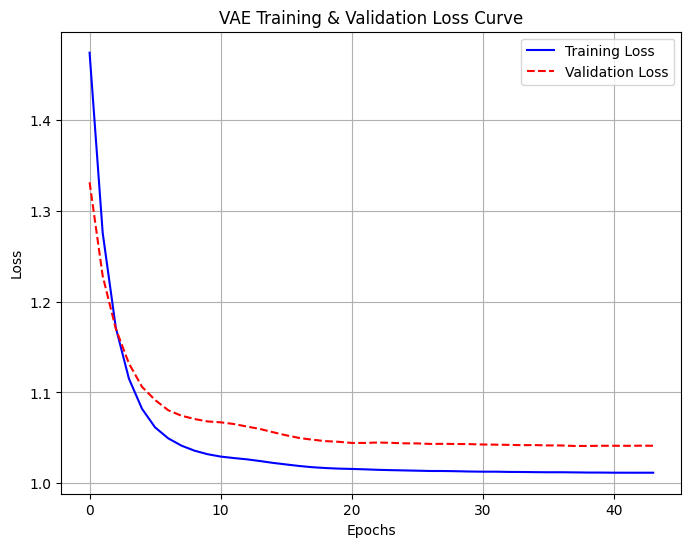

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:234: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


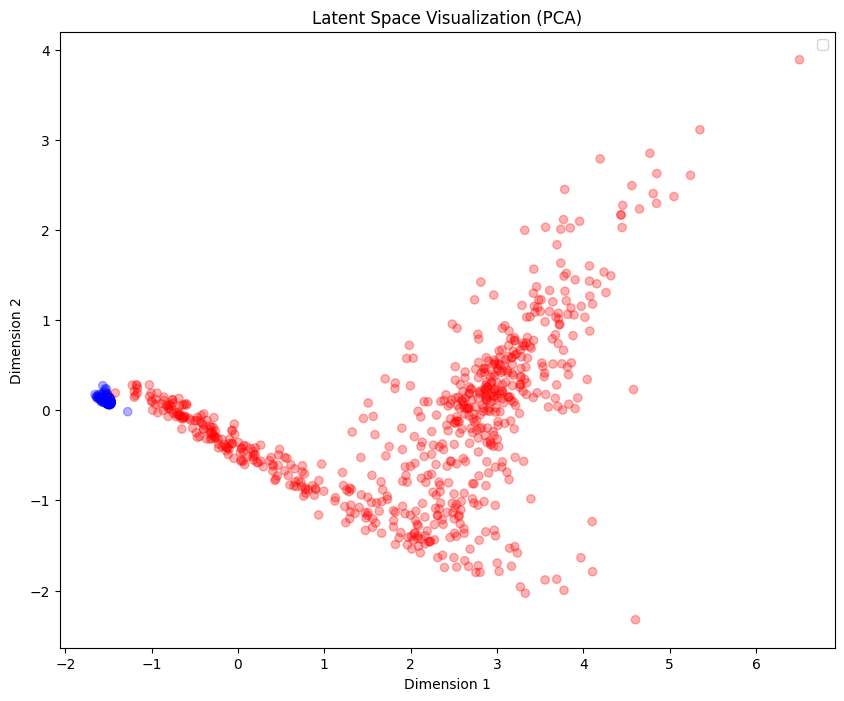

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:234: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


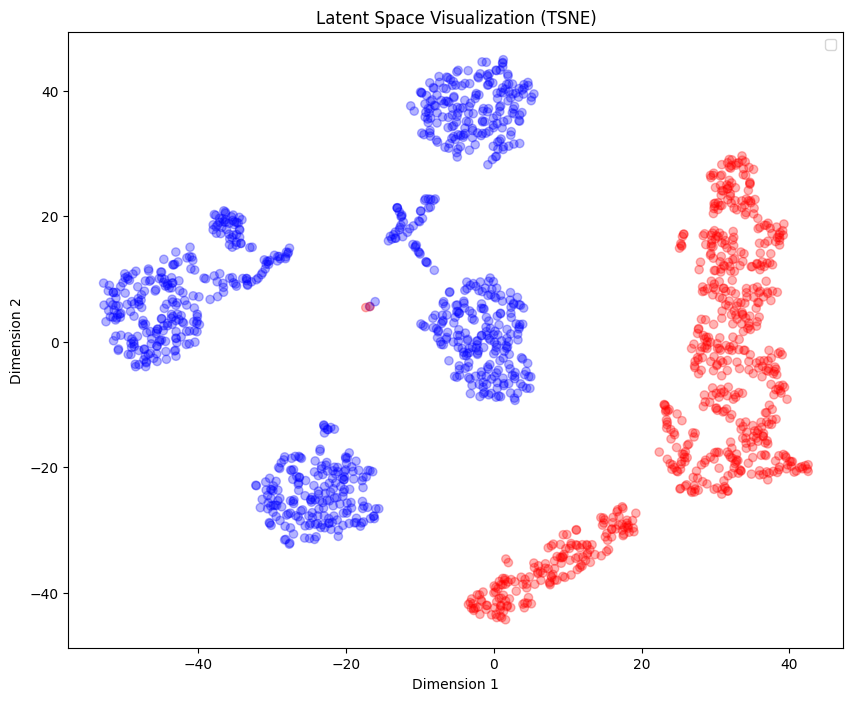

Get Mean and Variances completed in: 0.7344 seconds
Ball Tree completed in 0.1241 seconds
########### Latent Thhresholds ##############
Normal LATENT threshold: 0.0348544
########################################
Get Thresold from Train completed in 1.7924 seconds


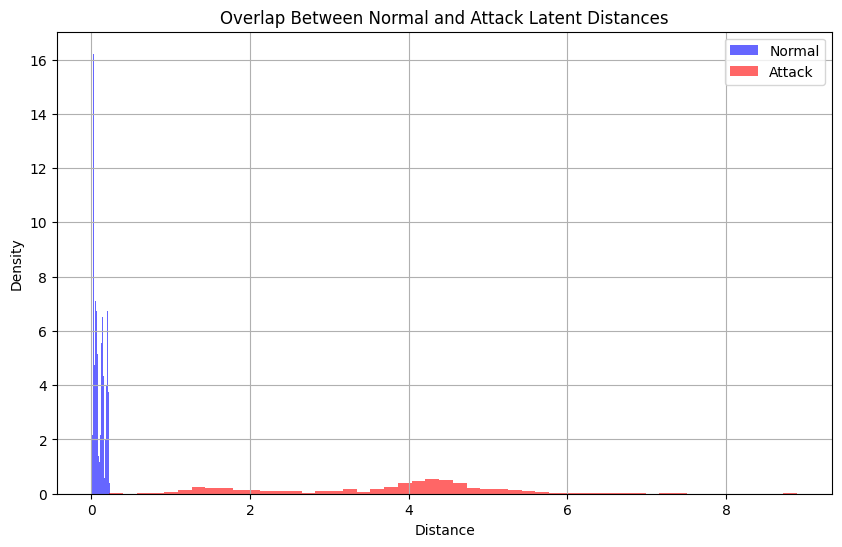

c:\Users\SCHUGD\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


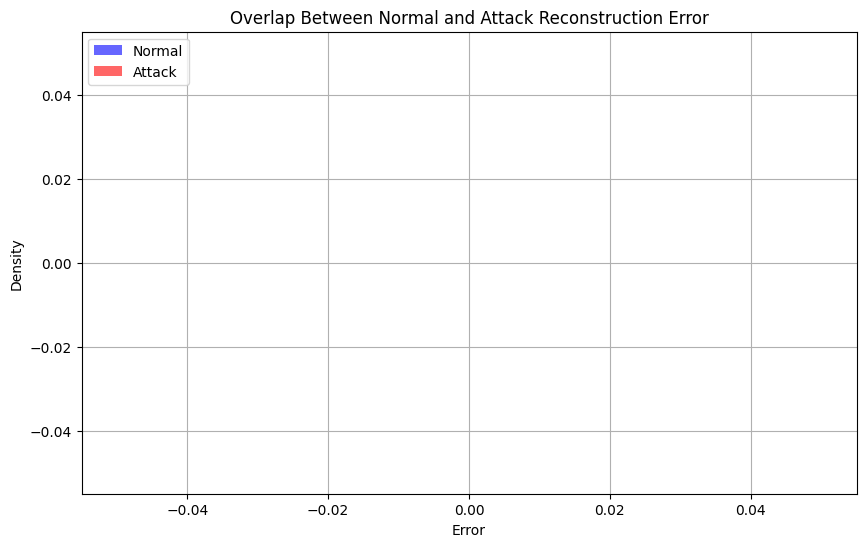

Anomaly Detection completed in : 15.7517 seconds
Recon memory: 0.00000000
Latent memory: 1597.30393219
Anomaly threshold: 0.0348544
Number of anomalies detected using LATENT: 668.0
######### Latent Distance Performance ############
Confusion Matrix:
[[916   0]
 [  2 668]]


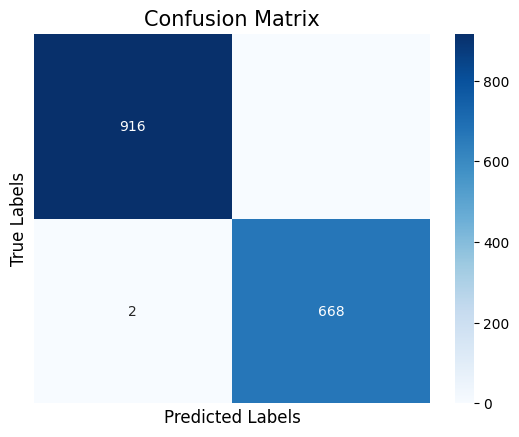

######### ############################ ############


In [56]:
reload(utils)
reload(train)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 100
n_samples = 10
learning_rate = 1e-04
weight_decay = 1e-06
learning_rate_disc = 5e-5 # FactorVAE

steps_anneal = epochs * len(train_dataset)  
print("steps: ", steps_anneal) 
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_VAE" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 10
beta = 2 # 50
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = True

# Hyperparameter search space
latent_dims = [10]  # Example values for latent dimension
beta_values = [2]


test_dataset = test_dataset_dos_hcrl

for latent_dim, beta in itertools.product(latent_dims, beta_values):
  time = datetime.now().strftime("%H-%M")
  model_name ="B_Threshold_VAE"
  #model_path s= f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

  cosine_decay_schedule = CosineDecay(
      1e-03, steps_anneal, alpha=alpha
  )

  #vae = Bernoulli_VAE(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size, bernoulli_prior_p= 0.5)
  #vae = VAE_Mean_Variance_Decoder(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
  vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

  #vae_semi = LR_SEMIVAE(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size, num_classes= 2, lambda_cls = 1)


  #optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
  optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
  discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

  train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                      n_samples, input_dim, latent_dim, batch_size,beta,
                                                                        gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                        model_path= "", train_dataset = train_dataset,test_dataset = test_dataset,
                                                                        val_dataset = val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


  plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
  reducer = None
  reducer = get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False, reducer = reducer)
  reducer = get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)

  if AD:
    reconstruction_AD = False
    latent_AD = True
    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= None)
    results, results_probs, distances, error_dict = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

**HyperParamter Search**

In [ ]:
reload(utils)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 100
n_samples = 10
learning_rate = 1e-04
weight_decay = 1e-06
learning_rate_disc = 5e-5 # FactorVAE

steps_anneal = epochs * len(train_dataset)  
print("steps: ", steps_anneal) 
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_TCVAE" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 10
beta = 2 # 50
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)

# Hyperparameter search space
latent_dims = [10]  # Example values for latent dimension
beta_values = [0.8,2,5,10,20]

it = 0
reconstruction_AD = True
latent_AD = True
# Iterate over all combinations
for latent_dim, beta in itertools.product(latent_dims, beta_values):
    time = datetime.now().strftime("%H-%M")
    model_name ="BASE_LSTM_VAE"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

    print(f"Training with: latent_dim={latent_dim}, beta={beta} validation_method={validation_method}")

    vae_1 = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_2 = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_3 = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_4 = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

    #vae_weakGen = VAE_weakGenerator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    #vae_2x = VAE_2x(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    #VAE_2x_weakGen = VAE_2x_weak_generator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

    #optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
    optimizer_1 = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_2 = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_3 = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_4 = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)

    #optimizer_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    #optimizer_2x = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    #optimizer_2x_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

    print("VAE 1111--------------")
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_1 = train_model(vae_1,optimizer_1,discriminator_optimizer, epochs,
                                                                        n_samples, input_dim, latent_dim, batch_size,beta,
                                                                          gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                          model_path= "", train_dataset = train_dataset,test_dataset = test_dataset,
                                                                          val_dataset = val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


    #plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    #get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    reducer = None
    reducer = get_latent_representations_label(vae_1, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False, reducer = reducer)
    reducer = get_latent_representations_label(vae_1, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae_1, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances, error_dict_1 = anomaly_detection(loaded_vae_1, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae, optimizer
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 22222--------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_2"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_2 = train_model(vae_2,optimizer_2,discriminator_optimizer, epochs,
                                                                        n_samples, input_dim, latent_dim, batch_size,beta,
                                                                          gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                          model_path= "", train_dataset = train_dataset,test_dataset = test_dataset,
                                                                          val_dataset = val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


    #plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    #get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    reducer = None
    reducer = get_latent_representations_label(vae_2, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False, reducer = reducer)
    reducer = get_latent_representations_label(vae_2, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae_2, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances, error_dict_2 = anomaly_detection(loaded_vae_2, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")
    
    del vae_2, optimizer_2
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X----------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_2x = train_model(vae_2x,optimizer_2x,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_2x, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae_2x, optimizer_2x
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X WEAK GENERATOR------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, VAE_2x_weakGen = train_model(VAE_2x_weakGen,optimizer_2x_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

   
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(VAE_2x_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type='TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del VAE_2x_weakGen, optimizer_2x_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')


**Iterative Training on Saved Model**

In [ ]:
# Regular HYPERPARAMETERS 
#input_dim = np.size(processeddataframe['features'][0])
input_dim = 42
epochs = 50
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 30  
beta = 0 # 20
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

time = datetime.now().strftime("%H-%M")
model_name ="BEST_VAE"
new_model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/Iter_BEST_{model_name}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


vae = keras.models.load_model(best_model_path)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
#optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=weight_decay)
optimizer = vae.optimizer
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path = new_model_path)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time, show_val= show_val)
#analyze_latent_variance(vae,train_dataset, test_dataset)
#analyze_kl_divergence(vae, train_dataset, test_dataset)
#get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'TSNE', save = True)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

if AD:
  reconstruction_AD = False
  latent_AD = True
  reconstruction_threshold, latent_threshold, mean_train, variance_train = get_threshold_from_train(model_path, reconstruction_AD, latent_AD)
  results, distances = anomaly_detection(vae, reconstruction_AD, latent_AD, mean_train, variance_train)
  reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time)

**Test Saved Model**

Latent Dimension = 38, Beta = 30, Gamma = 0, N_critic = 0, Beta_TC = 0, Validation Method = PLOT, Rows in Training Data = 100000, Batch Size = 1024


In [36]:
best_model_path = "./Resources/Models/LAT_HCRL_CarHacking_BetaVAE_EPOCHS21_LD10_BETA2_NT50000_INPUT19_13-43.keras"
load_vae = keras.models.load_model(best_model_path)
load_vae.trainable = False  # Freeze model weights
reducer = None
##reducer = get_latent_representations_label(load_vae, train_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, val_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, test_threshold_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, test_dataset_dos_hcrl, 0, 0 ,0,0,0,epoch = 0,name = "-",type='TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, test_dataset_fuzzy, 0, 0 ,0,0,0,epoch = 0,name = "-",type='TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, test_dataset_spoofing_gear, 0, 0 ,0,0,0,epoch = 0,name = "-",type='TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
#reducer = get_latent_representations_label(load_vae, test_dataset_spoofing_RPM, 0, 0 ,0,0,0,epoch = 0,name = "-",type='TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)

@tf.function
def profile_vae_inference(batch, n_samples):
    # Match your exact model call
    model_outputs = load_vae(batch, n_samples=n_samples, latent_only=False)
    reconstructed = model_outputs['reconstructed']
    mu = model_outputs['mu']
    logvar = model_outputs['logvar']
    return reconstructed, mu, logvar

# Create dummy input with correct shape
dummy_batch = tf.random.normal((32, 50, 19))  # Adjust batch size as needed
n_samples = 1  # Use the same n_samples you typically use

# Profile the model
tf.profiler.experimental.start('vae_profile_logs')
reconstructed, mu, logvar = profile_vae_inference(dummy_batch, n_samples)
tf.profiler.experimental.stop()

print("Profiling complete! Check 'vae_profile_logs' directory")
print(f"Input shape: {dummy_batch.shape}")
print(f"Reconstructed shape: {reconstructed.shape}")
print(f"Mu shape: {mu.shape}")
print(f"Logvar shape: {logvar.shape}")



Profiling complete! Check 'vae_profile_logs' directory
Input shape: (32, 50, 19)
Reconstructed shape: (1, 32, 50, 19)
Mu shape: (32, 10)
Logvar shape: (32, 10)


In [ ]:
import tensorflow as tf

# Your existing model loading
#best_model_path = "./Resources/Models/LAT_HCRL_CarHacking_BetaVAE_EPOCHS21_LD10_BETA2_NT50000_INPUT19_13-43.keras"
best_model_path = "./Resources/Models/FLOP_BetaVAE_EPOCHS43_LD10_BETA2_NT50000_INPUT19_12-41.keras"

model_path = best_model_path

## CLUSTERING ##
mean_train, variance_train = get_mean_variances(train_dataset, test = False, load_vae= None, model_path= model_path)
mixed_means, mixed_variances, mixed_labels = get_mean_variances(test_dataset, test = True, load_vae= None, model_path= model_path)

scaled_features, scaler = prepare_features(np.array(mean_train), np.array(variance_train))
mixed_scaled_features, mixed_scaler = prepare_features(np.array(mixed_means), np.array(mixed_variances))

iso_model = train_isolation_forest(scaled_features, contamination=0.005, n_estimators=100, random_state=42)
###

## BALL TREE ##


mean_train , variance_train = get_mean_variances(train_dataset, test = False, load_vae = load_vae, model_path= "")

# Preprocess your normal data
start_time_ball_tree = time.time()
combined_params = np.hstack([mean_train, variance_train])  # Combine mean and variance
tree = BallTree(combined_params, metric='pyfunc', func=bhattacharyya_distance_old_balltree)
print(f"Ball Tree completed in {time.time() - start_time_ball_tree:.4f} seconds")

# Estimate FLOPs
flops = estimate_isolation_forest_flops(iso_model, 1000)
print(f"Estimated FLOPs for {1000} samples: {flops:,}")

load_vae = keras.models.load_model(best_model_path)
load_vae.trainable = False



@tf.function
def profile_vae_inference(batch, n_samples, iso_model):
    model_outputs = load_vae(batch, n_samples=n_samples, latent_only=False)
    #mu = model_outputs['mu']

   
    #reconstructed = model_outputs['reconstructed']
    #mu = model_outputs['mu']
    #logvar = model_outputs['logvar']

    n_samples = reconstructed.shape[0]
    # Broadcast batch to match reconstructed's shape
    batch = tf.repeat(tf.expand_dims(batch, axis=0), reconstructed.shape[0], axis=0)

    #Compute reconstruction MSE error for continous features
    mse_errors = tf.reduce_mean(tf.square(batch - model_outputs['reconstructed']), axis=-1)  # Shape: (n_samples, batch_size, window_size)

    #reconstruction_errors = mse_errors

    #print(reconstruction_errors.shape)
    reconstruction_loss_batch = tf.reduce_mean(mse_errors, axis = (0,2))


    #return model_outputs['reconstructed'], model_outputs['mu'], model_outputs['logvar']
    #return model_outputs['mu']
    return model_outputs['reconstructed'], reconstruction_loss_batch

def get_flop_count():
    dummy_batch = tf.random.normal((512, 50, 19))  # Use batch_size=1 for per-sample FLOPs
    n_samples = 1
    
    # Get concrete function for profiling
    concrete_func = profile_vae_inference.get_concrete_function(dummy_batch, n_samples, iso_model)
    
    # Run profiler
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    
    # This will give you the FLOP count
    flops = tf.compat.v1.profiler.profile(
        graph=concrete_func.graph,
        run_meta=run_meta,
        options=opts
    )
    
    total_flops = flops.total_float_ops
    print(f"Total FLOPs: {total_flops:,}")
    print(f"Total FLOPs (scientific notation): {total_flops:.2e}")
    
    return total_flops

# Get and print FLOP count
flops = get_flop_count()

Get Mean and Variances completed in: 1.0728 seconds
Get Mean and Variances completed in: 1.0964 seconds
Isolation Forest training completed in 0.1007 seconds
Estimated FLOPs for 1000 samples: 1,100,000
Total FLOPs: 109,163,522
Total FLOPs (scientific notation): 1.09e+08


In [ ]:
model_path = "./Resources/Models/B0.8_BetaVAE_EPOCHS33_LD10_BETA0.8_NT50000_INPUT19_13-14.keras"
model_name = "EmbeddingBetaVAE"
#model_path = best_model_path
reconstruction_AD = True
latent_AD = True
reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= None)
results, results_probs, distances, errors_dict = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

# Assuming you have your errors_dict ready
normal = errors_dict['normal_rec']
attack = errors_dict['attack_rec']

results = analyze_error_overlap(normal,attack)
print_summary(results)
visualize_overlap_rec(errors_dict, results)

In [ ]:
model_path = "./Resources/Models/B2_BetaVAE_EPOCHS32_LD10_BETA2_NT50000_INPUT19_13-19.keras"
model_name = "EmbeddingBetaVAE"
#model_path = best_model_path
reconstruction_AD = True
latent_AD = True


reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= None)

results, results_probs, distances, errors_dict_dos_hcrl = anomaly_detection(loaded_vae, test_dataset_dos_hcrl , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
results, results_probs, distances, errors_dict_spoofing_gear = anomaly_detection(loaded_vae, test_dataset_spoofing_gear , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
results, results_probs, distances, errors_dict_spoofing_rpm = anomaly_detection(loaded_vae, test_dataset_spoofing_RPM , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
results, results_probs, distances, errors_dict_fuzzy = anomaly_detection(loaded_vae, test_dataset_fuzzy , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)

# Assuming you have your errors_dict ready
#normal = errors_dict['normal_rec']
#attack = errors_dict['attack_lat']

#results = analyze_error_overlap(normal,attack)
#print_summary(results)
#visualize_overlap_lat(errors_dict, results)

# Example usage:

# Set up your data structure:
normal_errors_rec = {
    'normal_rec': errors_dict_dos_hcrl['normal_lat'],
    'normal_lat': errors_dict_dos_hcrl['normal_lat']
}

attack_scenarios = {
    'DoS[HCRL]': {
        'attack_rec': errors_dict_dos_hcrl['attack_lat'],
        'attack_lat': errors_dict_dos_hcrl['attack_lat']
    },
    'Spoofing[Gear]': {
        'attack_rec': errors_dict_spoofing_gear['attack_lat'],
        'attack_lat': errors_dict_spoofing_gear['attack_lat']
    },
    'Spoofing[RPM]': {
        'attack_rec': errors_dict_spoofing_rpm['attack_lat'],
        'attack_lat': errors_dict_spoofing_rpm['attack_lat']
    },
    'Fuzzy': {
        'attack_rec': errors_dict_fuzzy['attack_lat'],
        'attack_lat': errors_dict_fuzzy['attack_lat'],
    }
}



# Run analysis
results = analyze_multiple_attack_scenarios(normal_errors_rec, attack_scenarios)

# Display results
print_comprehensive_summary(results)

In [ ]:
# Run analysis
results = analyze_multiple_attack_scenarios(normal_errors_rec, attack_scenarios)

# Display results
print_comprehensive_summary(results)
visualize_multiple_attacks(results)


In [ ]:
model_path = "./Resources/Models/LAT_HCRL_CarHacking_BetaVAE_EPOCHS21_LD10_BETA2_NT50000_INPUT19_13-43.keras"

mean_train, variance_train = get_mean_variances(train_dataset, test = False, load_vae= None, model_path= model_path)
mixed_means, mixed_variances, mixed_labels = get_mean_variances(test_dataset, test = True, load_vae= None, model_path= model_path)
mixed2_means, mixed2_variances, mixed2_labels = get_mean_variances(test_threshold_dataset, test = True, load_vae= None, model_path= model_path)

In [ ]:
print(mixed_labels)

In [ ]:
mixed_means = mixed_means[:5000]
mixed_variances = mixed_variances[:5000]
mixed_labels = mixed_labels[:5000]

print(len(mean_train))
print(sum(mixed_labels), len(mixed_labels) - sum(mixed_labels))
print(sum(mixed2_labels), len(mixed2_labels) - sum(mixed2_labels))

In [ ]:
#print(np.array(mean_train).min())
scaled_features, scaler = prepare_features(np.array(mean_train), np.array(variance_train))
mixed_scaled_features, mixed_scaler = prepare_features(np.array(mixed_means), np.array(mixed_variances))

iso_model = train_isolation_forest(scaled_features, contamination=0.005, n_estimators=100, random_state=42)
#svm_model = train_one_class_svm(scaled_features, nu=0.00001, kernel='rbf', gamma='scale')
#hdbscan_model = train_hdbscan_detector(np.array(mixed_means),min_cluster_size=500,min_samples=500, metric='cosine')


iso_anomaly_mask, iso_anomaly_scores = detect_anomalies_isolation_forest(iso_model, mixed_scaled_features)
#svm_anomaly_mask, svm_anomaly_scores = detect_anomalies_one_class_svm(svm_model, mixed_scaled_features)
#hdbscan_outliers, test_labels, strengths = detect_anomalies_hdbscan(hdbscan_model , mixed_scaled_features)

iso_pca = visualize_anomalies(mixed_scaled_features, iso_anomaly_mask, "Isolation Forest tSNE")
#svm_pca = visualize_anomalies(mixed_scaled_features, svm_anomaly_mask, "SVM TSNE")

#hdbscan_pca = visualize_anomalies(mixed_scaled_features, hdbscan_outliers,"HDBSCAN TSNE")
#visualize_results(scaled_features, mixed_scaled_features, hdbscan_outliers)

evaluate_anomaly_detector_verbose(iso_anomaly_scores, np.array(mixed_labels), "Isolation Forest Accuracy")
#evaluate_anomaly_detector(svm_anomaly_scores, mixed_labels, "SVM Accuracy")
#evaluate_anomaly_detector(hdbscan_outliers, mixed_labels, "HDBSCAN Accuracy")

#evaluation = evaluate_hdbscan_detector(mixed_labels, anomaly_mask)




**BENCHMARK**

In [67]:

model = keras.models.load_model('./Resources/Models/REC_HCRL_CarHacking_BetaVAE_EPOCHS34_LD10_BETA0.8_NT50000_INPUT19_10-12.keras')

total_params = model.count_params()
memory_in_bytes = total_params * 4  # float32 = 4 bytes
memory_in_mb = memory_in_bytes / (1024 ** 2)

print(f"Approximate model size in memory: {memory_in_mb:.2f} MB")

ValueError: A total of 6 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(10, 256), Received: value.shape=(10, 512). Target variable: <Variable path=sequential_103/lstm_95/lstm_cell/kernel, shape=(10, 256), dtype=float32, value=[[ 0.03180246  0.06505424  0.03223687 ... -0.06949215 -0.1143257
   0.125563  ]
 [-0.14306225 -0.13196605  0.12222826 ... -0.09579253  0.03232926
  -0.06652671]
 [ 0.13731539 -0.05228457  0.0811073  ... -0.08506726 -0.08335624
  -0.00855117]
 ...
 [ 0.04003118 -0.13131583  0.10968947 ...  0.11970267  0.11834359
  -0.00220506]
 [ 0.09424406  0.13294765 -0.11784205 ... -0.02085376 -0.03892691
  -0.08038253]
 [ 0.1376949  -0.07938661 -0.06023002 ... -0.02782356 -0.04535194
   0.13385296]]>

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>, <Dense name=dense_159, built=True>, <LSTMCell name=lstm_cell, built=True>, <Dense name=dense_158, built=True>, <Dense name=dense_157, built=True>, <keras.src.optimizers.adamw.AdamW object at 0x000001E6C3F740D0>]

In [ ]:
def estimate_model_memory(model, batch_size=1):
    # Parameter memory
    total_params = model.count_params()
    param_memory = total_params * 4  # float32
    
    # Estimate activation memory for inference
    # This is approximate - actual memory depends on model architecture
    activation_memory = 0
    for layer in model.layers:
        if hasattr(layer, 'output_shape') and layer.output_shape:
            shape = layer.output_shape
            if shape and all(dim is not None for dim in shape[1:]):  # Skip batch dimension
                layer_memory = batch_size * np.prod(shape[1:]) * 4  # float32
                activation_memory += layer_memory
    
    total_memory = param_memory + activation_memory
    return {
        'params_mb': param_memory / (1024**2),
        'activations_mb': activation_memory / (1024**2),
        'total_mb': total_memory / (1024**2)
    }

memory_info = estimate_model_memory(model, batch_size=1)
print(f"Parameters: {memory_info['params_mb']:.2f} MB")
print(f"Activations: {memory_info['activations_mb']:.2f} MB")
print(f"Total estimated: {memory_info['total_mb']:.2f} MB")

In [ ]:
import psutil
import os

# Monitor actual memory usage
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss / (1024**2)

# Load and use your model
model = keras.models.load_model('./Resources/Models/REC_HCRL_CarHacking_BetaVAE_EPOCHS34_LD10_BETA0.8_NT50000_INPUT19_10-12.keras')

memory_after = process.memory_info().rss / (1024**2)
print(f"Memory increase after loading model: {memory_after - memory_before:.2f} MB")

In [ ]:
import psutil
import os
import pickle
import numpy as np
from sklearn.neighbors import BallTree

# First, create and save your BallTree (do this once)
def create_and_save_balltree(n_samples, n_dimensions=6, save_path='./balltree.pkl'):
    # Create your reference data (replace with your actual latent representations)
    reference_data = np.random.random((n_samples, n_dimensions)).astype(np.float32)
    
    # Create BallTree
    tree = BallTree(reference_data, metric='euclidean')
    
    # Save it
    with open(save_path, 'wb') as f:
        pickle.dump(tree, f)
    
    print(f"BallTree with {n_samples} samples saved to {save_path}")
    return tree

# Create and save (run this once)
create_and_save_balltree(n_samples=50000)  # Adjust n_samples as needed
# Now measure loading memory (equivalent to your model loading)
def measure_balltree_loading_memory(balltree_path='./balltree.pkl'):
    process = psutil.Process(os.getpid())
    memory_before = process.memory_info().rss / (1024**2)
    
    # Load the saved BallTree
    with open(balltree_path, 'rb') as f:
        tree = pickle.load(f)
    
    memory_after = process.memory_info().rss / (1024**2)
    
    print(f"Memory increase after loading BallTree: {memory_after - memory_before:.2f} MB")
    return tree, memory_after - memory_before

# Measure loading memory
tree, balltree_memory = measure_balltree_loading_memory()

In [25]:
import psutil
import os
import gc

# Memory measurement function
def measure_memory_usage2(func, *args, **kwargs):
    process = psutil.Process(os.getpid())
    
    # Trigger garbage collection before measurement
    gc.collect()

    mem_before = process.memory_info().rss  # Memory before running the function
    
    result = func(*args, **kwargs)  # Run the function

    mem_after = process.memory_info().rss  # Memory after the function has run

    # Convert bytes to MB
    mem_used = (mem_after - mem_before) / 1024 / 1024
    return mem_used, result


In [49]:
import tracemalloc

def measure_memory_usage(func, *args, **kwargs):
    tracemalloc.start()
    result = func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / (1024 * 1024), result  # peak memory in MB


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

def analyze_error_overlap(normal_rec, attack_rec):
    """
    Comprehensive analysis of reconstruction error overlap between normal and attack samples
    
    Args:
        errors_dict: Dictionary with keys 'normal_rec', 'attack_rec', 'normal_lat', 'attack_lat'
    
    Returns:
        Dictionary containing various overlap metrics
    """
    
    #normal_rec = np.array(errors_dict['normal_rec'])
    #attack_rec = np.array(errors_dict['attack_rec'])
    
    # 1. BASIC STATISTICS
    normal_stats = {
        'mean': np.mean(normal_rec),
        'std': np.std(normal_rec),
        'median': np.median(normal_rec),
        'min': np.min(normal_rec),
        'max': np.max(normal_rec),
        'q25': np.percentile(normal_rec, 25),
        'q75': np.percentile(normal_rec, 75)
    }
    
    attack_stats = {
        'mean': np.mean(attack_rec),
        'std': np.std(attack_rec),
        'median': np.median(attack_rec),
        'min': np.min(attack_rec),
        'max': np.max(attack_rec),
        'q25': np.percentile(attack_rec, 25),
        'q75': np.percentile(attack_rec, 75)
    }
    
    # 2. OVERLAP REGION ANALYSIS
    # Find the overlapping range
    overlap_min = max(np.min(normal_rec), np.min(attack_rec))
    overlap_max = min(np.max(normal_rec), np.max(attack_rec))
    overlap_range = max(0, overlap_max - overlap_min)
    
    # Total range covered by both distributions
    total_min = min(np.min(normal_rec), np.min(attack_rec))
    total_max = max(np.max(normal_rec), np.max(attack_rec))
    total_range = total_max - total_min
    
    # Overlap ratio
    overlap_ratio = overlap_range / total_range if total_range > 0 else 0
    
    # 3. HISTOGRAM-BASED OVERLAP DENSITY
    # Create histograms with same bins
    bins = np.linspace(total_min, total_max, 100)
    normal_hist, _ = np.histogram(normal_rec, bins=bins, density=True)
    attack_hist, _ = np.histogram(attack_rec, bins=bins, density=True)
    
    # Calculate overlap density (intersection of normalized histograms)
    overlap_density = np.sum(np.minimum(normal_hist, attack_hist)) * (bins[1] - bins[0])
    
    # 4. STATISTICAL SEPARATION MEASURES
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(normal_rec) - 1) * normal_stats['std']**2 + 
                          (len(attack_rec) - 1) * attack_stats['std']**2) / 
                         (len(normal_rec) + len(attack_rec) - 2))
    cohens_d = abs(normal_stats['mean'] - attack_stats['mean']) / pooled_std
    
    # Kolmogorov-Smirnov test (measures maximum difference between CDFs)
    ks_statistic, ks_pvalue = stats.ks_2samp(normal_rec, attack_rec)
    
    # Mann-Whitney U test
    mw_statistic, mw_pvalue = stats.mannwhitneyu(normal_rec, attack_rec, alternative='two-sided')
    
    # 5. CLASSIFICATION-BASED MARGIN ANALYSIS
    # Create labels (0 for normal, 1 for attack)
    y_true = np.concatenate([np.zeros(len(normal_rec)), np.ones(len(attack_rec))])
    y_scores = np.concatenate([normal_rec, attack_rec])
    
    # ROC AUC (perfect separation = 1.0, random = 0.5)
    auc_score = roc_auc_score(y_true, y_scores)
    
    # Find optimal threshold using ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)  # Youden's J statistic
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate margin metrics at optimal threshold
    normal_below_threshold = np.sum(normal_rec < optimal_threshold)
    attack_above_threshold = np.sum(attack_rec >= optimal_threshold)
    
    # True positive rate and false positive rate at optimal threshold
    tpr_optimal = attack_above_threshold / len(attack_rec)
    fpr_optimal = (len(normal_rec) - normal_below_threshold) / len(normal_rec)
    
    # 6. MARGIN DENSITY MEASURES
    # Calculate density of samples in the overlap region
    normal_in_overlap = np.sum((normal_rec >= overlap_min) & (normal_rec <= overlap_max))
    attack_in_overlap = np.sum((attack_rec >= overlap_min) & (attack_rec <= overlap_max))
    
    # Margin density (proportion of samples in overlap region)
    normal_overlap_density = normal_in_overlap / len(normal_rec) if len(normal_rec) > 0 else 0
    attack_overlap_density = attack_in_overlap / len(attack_rec) if len(attack_rec) > 0 else 0
    total_overlap_density = (normal_in_overlap + attack_in_overlap) / (len(normal_rec) + len(attack_rec))
    
    # 7. SEPARABILITY INDEX (custom metric)
    # Combines multiple factors: statistical separation, overlap density, and classification performance
    separability_index = (cohens_d * ks_statistic * auc_score) / (1 + total_overlap_density)
    
    return {
        'basic_stats': {
            'normal': normal_stats,
            'attack': attack_stats
        },
        'overlap_analysis': {
            'overlap_range': overlap_range,
            'total_range': total_range,
            'overlap_ratio': overlap_ratio,
            'overlap_min': overlap_min,
            'overlap_max': overlap_max
        },
        'margin_density': {
            'histogram_overlap_density': overlap_density,
            'normal_overlap_density': normal_overlap_density,
            'attack_overlap_density': attack_overlap_density,
            'total_overlap_density': total_overlap_density
        },
        'statistical_measures': {
            'cohens_d': cohens_d,
            'ks_statistic': ks_statistic,
            'ks_pvalue': ks_pvalue,
            'mann_whitney_statistic': mw_statistic,
            'mann_whitney_pvalue': mw_pvalue
        },
        'classification_metrics': {
            'auc_score': auc_score,
            'optimal_threshold': optimal_threshold,
            'tpr_at_optimal': tpr_optimal,
            'fpr_at_optimal': fpr_optimal
        },
        'summary_metrics': {
            'separability_index': separability_index,
            'margin_density_score': total_overlap_density,  # Lower is better for separation
            'separation_quality': 1 - total_overlap_density  # Higher is better for separation
        }
    }

def visualize_overlap_rec(errors_dict, analysis_results):
    """
    Create visualizations for the overlap analysis
    """
    normal_rec = np.array(errors_dict['normal_rec'])
    attack_rec = np.array(errors_dict['attack_rec'])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Overlapping histograms
    axes[0, 0].hist(normal_rec, bins=50, alpha=0.7, label='Normal', density=True, color='blue')
    axes[0, 0].hist(attack_rec, bins=50, alpha=0.7, label='Attack', density=True, color='red')
    axes[0, 0].axvline(analysis_results['classification_metrics']['optimal_threshold'], 
                       color='green', linestyle='--', label='Optimal Threshold')
    axes[0, 0].set_xlabel('Reconstruction Error')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Distribution Overlap')
    axes[0, 0].legend()
    
    # 2. Box plots
    data_to_plot = [normal_rec, attack_rec]
    axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Attack'])
    axes[0, 1].set_ylabel('Reconstruction Error')
    axes[0, 1].set_title('Box Plot Comparison')
    
    # 3. Cumulative distributions
    x_normal = np.sort(normal_rec)
    y_normal = np.arange(1, len(x_normal) + 1) / len(x_normal)
    x_attack = np.sort(attack_rec)
    y_attack = np.arange(1, len(x_attack) + 1) / len(x_attack)
    
    axes[1, 0].plot(x_normal, y_normal, label='Normal', color='blue')
    axes[1, 0].plot(x_attack, y_attack, label='Attack', color='red')
    axes[1, 0].set_xlabel('Reconstruction Error')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution Functions')
    axes[1, 0].legend()
    
    # 4. ROC curve
    from sklearn.metrics import roc_curve
    y_true = np.concatenate([np.zeros(len(normal_rec)), np.ones(len(attack_rec))])
    y_scores = np.concatenate([normal_rec, attack_rec])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    axes[1, 1].plot(fpr, tpr, color='blue', 
                    label=f'ROC (AUC = {analysis_results["classification_metrics"]["auc_score"]:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


def visualize_overlap_lat(errors_dict, analysis_results):
    """
    Create visualizations for the overlap analysis
    """
    normal_rec = np.array(errors_dict['normal_lat'])
    attack_rec = np.array(errors_dict['attack_lat'])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Overlapping histograms
    axes[0, 0].hist(normal_rec, bins=50, alpha=0.7, label='Normal', density=True, color='blue')
    axes[0, 0].hist(attack_rec, bins=50, alpha=0.7, label='Attack', density=True, color='red')
    axes[0, 0].axvline(analysis_results['classification_metrics']['optimal_threshold'], 
                       color='green', linestyle='--', label='Optimal Threshold')
    axes[0, 0].set_xlabel('Latent Distance')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Distribution Overlap')
    axes[0, 0].legend()
    
    # 2. Box plots
    data_to_plot = [normal_rec, attack_rec]
    axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Attack'])
    axes[0, 1].set_ylabel('Latent Distance')
    axes[0, 1].set_title('Box Plot Comparison')
    
    # 3. Cumulative distributions
    x_normal = np.sort(normal_rec)
    y_normal = np.arange(1, len(x_normal) + 1) / len(x_normal)
    x_attack = np.sort(attack_rec)
    y_attack = np.arange(1, len(x_attack) + 1) / len(x_attack)
    
    axes[1, 0].plot(x_normal, y_normal, label='Normal', color='blue')
    axes[1, 0].plot(x_attack, y_attack, label='Attack', color='red')
    axes[1, 0].set_xlabel('Latent Distance')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution Functions')
    axes[1, 0].legend()
    
    # 4. ROC curve
    from sklearn.metrics import roc_curve
    y_true = np.concatenate([np.zeros(len(normal_rec)), np.ones(len(attack_rec))])
    y_scores = np.concatenate([normal_rec, attack_rec])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    axes[1, 1].plot(fpr, tpr, color='blue', 
                    label=f'ROC (AUC = {analysis_results["classification_metrics"]["auc_score"]:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def print_summary(analysis_results):
    """
    Print a summary of key metrics
    """
    print("=== RECONSTRUCTION or Latent ERROR OVERLAP ANALYSIS ===\n")
    
    print("KEY MARGIN METRICS:")
    print(f"• Total Overlap Density: {analysis_results['margin_density']['total_overlap_density']:.4f}")
    print(f"• Separability Index: {analysis_results['summary_metrics']['separability_index']:.4f}")
    print(f"• Separation Quality: {analysis_results['summary_metrics']['separation_quality']:.4f}")
    print(f"• AUC Score: {analysis_results['classification_metrics']['auc_score']:.4f}")
    print(f"• Cohen's d (Effect Size): {analysis_results['statistical_measures']['cohens_d']:.4f}")
    
    print(f"\nOVERLAP REGION:")
    print(f"• Overlap Range: {analysis_results['overlap_analysis']['overlap_range']:.4f}")
    print(f"• Overlap Ratio: {analysis_results['overlap_analysis']['overlap_ratio']:.4f}")
    
    print(f"\nCLASSIFICATION PERFORMANCE:")
    print(f"• Optimal Threshold: {analysis_results['classification_metrics']['optimal_threshold']:.4f}")
    print(f"• TPR at Optimal: {analysis_results['classification_metrics']['tpr_at_optimal']:.4f}")
    print(f"• FPR at Optimal: {analysis_results['classification_metrics']['fpr_at_optimal']:.4f}")

# Example usage:
"""
# Assuming you have your errors_dict ready
results = analyze_error_overlap(errors_dict)
print_summary(results)
visualize_overlap(errors_dict, results)

# For comparing across different beta values, you can track these key metrics:
key_metrics_for_beta_comparison = {
    'total_overlap_density': results['margin_density']['total_overlap_density'],
    'separability_index': results['summary_metrics']['separability_index'],
    'auc_score': results['classification_metrics']['auc_score'],
    'cohens_d': results['statistical_measures']['cohens_d']
}
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns

def analyze_multiple_attack_scenarios(normal_errors, attack_scenarios_dict):
    """
    Comprehensive analysis of reconstruction error overlap between normal and multiple attack scenarios
    
    Args:
        normal_errors: Dictionary with keys 'normal_rec', 'normal_lat' for normal samples
        attack_scenarios_dict: Dictionary where keys are attack names and values are dictionaries 
                              with keys 'attack_rec', 'attack_lat'
    
    Returns:
        Dictionary containing analysis results for each attack scenario
    """
    
    normal_rec = np.array(normal_errors['normal_rec'])
    results = {}
    
    attack_names = list(attack_scenarios_dict.keys())
    
    for attack_name, attack_errors in attack_scenarios_dict.items():
        attack_rec = np.array(attack_errors['attack_rec'])
        
        # Run individual analysis for each attack scenario
        individual_result = analyze_single_attack_scenario(normal_rec, attack_rec, attack_name)
        results[attack_name] = individual_result
    
    # Add comparative analysis across all scenarios
    results['comparative_analysis'] = analyze_comparative_metrics(normal_rec, attack_scenarios_dict)
    
    return results

def analyze_single_attack_scenario(normal_rec, attack_rec, attack_name):
    """
    Analyze overlap between normal and a single attack scenario
    """
    
    # 1. BASIC STATISTICS
    normal_stats = {
        'mean': np.mean(normal_rec),
        'std': np.std(normal_rec),
        'median': np.median(normal_rec),
        'min': np.min(normal_rec),
        'max': np.max(normal_rec),
        'q25': np.percentile(normal_rec, 25),
        'q75': np.percentile(normal_rec, 75)
    }
    
    attack_stats = {
        'mean': np.mean(attack_rec),
        'std': np.std(attack_rec),
        'median': np.median(attack_rec),
        'min': np.min(attack_rec),
        'max': np.max(attack_rec),
        'q25': np.percentile(attack_rec, 25),
        'q75': np.percentile(attack_rec, 75)
    }
    
    # 2. OVERLAP REGION ANALYSIS
    overlap_min = max(np.min(normal_rec), np.min(attack_rec))
    overlap_max = min(np.max(normal_rec), np.max(attack_rec))
    overlap_range = max(0, overlap_max - overlap_min)
    
    total_min = min(np.min(normal_rec), np.min(attack_rec))
    total_max = max(np.max(normal_rec), np.max(attack_rec))
    total_range = total_max - total_min
    
    overlap_ratio = overlap_range / total_range if total_range > 0 else 0
    
    # 3. HISTOGRAM-BASED OVERLAP DENSITY
    bins = np.linspace(total_min, total_max, 100)
    normal_hist, _ = np.histogram(normal_rec, bins=bins, density=True)
    attack_hist, _ = np.histogram(attack_rec, bins=bins, density=True)
    
    overlap_density = np.sum(np.minimum(normal_hist, attack_hist)) * (bins[1] - bins[0])
    
    # 4. STATISTICAL SEPARATION MEASURES
    pooled_std = np.sqrt(((len(normal_rec) - 1) * normal_stats['std']**2 + 
                          (len(attack_rec) - 1) * attack_stats['std']**2) / 
                         (len(normal_rec) + len(attack_rec) - 2))
    cohens_d = abs(normal_stats['mean'] - attack_stats['mean']) / pooled_std
    
    ks_statistic, ks_pvalue = stats.ks_2samp(normal_rec, attack_rec)
    mw_statistic, mw_pvalue = stats.mannwhitneyu(normal_rec, attack_rec, alternative='two-sided')
    
    # 5. CLASSIFICATION-BASED MARGIN ANALYSIS
    y_true = np.concatenate([np.zeros(len(normal_rec)), np.ones(len(attack_rec))])
    y_scores = np.concatenate([normal_rec, attack_rec])
    
    auc_score = roc_auc_score(y_true, y_scores)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    normal_below_threshold = np.sum(normal_rec < optimal_threshold)
    attack_above_threshold = np.sum(attack_rec >= optimal_threshold)
    
    tpr_optimal = attack_above_threshold / len(attack_rec)
    fpr_optimal = (len(normal_rec) - normal_below_threshold) / len(normal_rec)
    

    # 6. PRECISION-RECALL CURVE
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc_score = average_precision_score(y_true, y_scores)

    # 6. MARGIN DENSITY MEASURES
    normal_in_overlap = np.sum((normal_rec >= overlap_min) & (normal_rec <= overlap_max))
    attack_in_overlap = np.sum((attack_rec >= overlap_min) & (attack_rec <= overlap_max))
    
    normal_overlap_density = normal_in_overlap / len(normal_rec) if len(normal_rec) > 0 else 0
    attack_overlap_density = attack_in_overlap / len(attack_rec) if len(attack_rec) > 0 else 0
    total_overlap_density = (normal_in_overlap + attack_in_overlap) / (len(normal_rec) + len(attack_rec))
    
    # 7. SEPARABILITY INDEX
    separability_index = (cohens_d * ks_statistic * auc_score) / (1 + total_overlap_density)
    
    return {
        'attack_name': attack_name,
        'basic_stats': {
            'normal': normal_stats,
            'attack': attack_stats
        },
        'overlap_analysis': {
            'overlap_range': overlap_range,
            'total_range': total_range,
            'overlap_ratio': overlap_ratio,
            'overlap_min': overlap_min,
            'overlap_max': overlap_max
        },
        'margin_density': {
            'histogram_overlap_density': overlap_density,
            'normal_overlap_density': normal_overlap_density,
            'attack_overlap_density': attack_overlap_density,
            'total_overlap_density': total_overlap_density
        },
        'statistical_measures': {
            'cohens_d': cohens_d,
            'ks_statistic': ks_statistic,
            'ks_pvalue': ks_pvalue,
            'mann_whitney_statistic': mw_statistic,
            'mann_whitney_pvalue': mw_pvalue
        },
        'classification_metrics': {
            'auc_score': auc_score,
            'pr_auc_score': pr_auc_score,  
            'optimal_threshold': optimal_threshold,
            'tpr_at_optimal': tpr_optimal,
            'fpr_at_optimal': fpr_optimal,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds,
            'precision': precision,  
            'recall': recall,        
            'pr_thresholds': pr_thresholds  
        },
        'summary_metrics': {
            'separability_index': separability_index,
            'margin_density_score': total_overlap_density,
            'separation_quality': 1 - total_overlap_density
        }
    }

def analyze_comparative_metrics(normal_rec, attack_scenarios_dict):
    """
    Analyze comparative metrics across all attack scenarios
    """
    attack_names = list(attack_scenarios_dict.keys())
    
    # Collect all attack data for global analysis
    all_attack_data = {}
    for name, errors in attack_scenarios_dict.items():
        all_attack_data[name] = np.array(errors['attack_rec'])
    
    # Find global min/max for consistent binning
    all_data = [normal_rec] + list(all_attack_data.values())
    global_min = min(np.min(data) for data in all_data)
    global_max = max(np.max(data) for data in all_data)
    
    return {
        'attack_names': attack_names,
        'global_range': (global_min, global_max),
        'normal_data': normal_rec,
        'attack_data': all_attack_data
    }

def visualize_multiple_attacks(results):
    """
    Create comprehensive visualizations for multiple attack scenarios
    """
    attack_names = results['comparative_analysis']['attack_names']
    normal_rec = results['comparative_analysis']['normal_data']
    attack_data = results['comparative_analysis']['attack_data']
    global_min, global_max = results['comparative_analysis']['global_range']

    # ADD THIS: Clamp the range to focus on the main data
    # Option A: Use percentiles to remove outliers
    all_data_combined = np.concatenate([normal_rec] + list(attack_data.values()))
    global_min = np.percentile(all_data_combined, 1)   # 1st percentile
    global_max = np.percentile(all_data_combined, 99)  # 99th percentile
    
    # Option B: Set manual limits if you know reasonable ranges
    global_min = max(global_min, 0)      # Don't go below 0
    global_max = min(global_max, 50)     # Cap at 10 (adjust as needed)

    # Define colors for each attack scenario
    colors = ['red', 'orange', 'green', 'purple', 'brown', 'pink']
    attack_colors = dict(zip(attack_names, colors[:len(attack_names)]))
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Overlapping histograms (2x2 grid, top-left)
    ax1 = plt.subplot(3, 3, 1)
    bins = np.linspace(global_min, global_max, 50)
    ax1.hist(normal_rec, bins=bins, alpha=0.7, label='Normal', density=True, color='blue')
    
    for attack_name, attack_rec in attack_data.items():
        ax1.hist(attack_rec, bins=bins, alpha=0.6, label=attack_name, 
                density=True, color=attack_colors[attack_name])
    
    ax1.set_xlabel('Latent Distance')
    ax1.set_ylabel('Density')
    ax1.set_title('Distribution Overlap - All HCRL Scenarios')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Box plots comparison
    ax2 = plt.subplot(3, 3, 2)
    data_to_plot = [normal_rec] + [attack_data[name] for name in attack_names]
    labels = ['Normal'] + attack_names
    
    box_plot = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # Color the boxes
    box_plot['boxes'][0].set_facecolor('lightblue')  # Normal
    for i, attack_name in enumerate(attack_names):
        box_plot['boxes'][i+1].set_facecolor(attack_colors[attack_name])
    
    ax2.set_ylabel('Latent Distance')
    ax2.set_title('Box Plot Comparison')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Cumulative distributions
    ax3 = plt.subplot(3, 3, 3)
    x_normal = np.sort(normal_rec)
    y_normal = np.arange(1, len(x_normal) + 1) / len(x_normal)
    ax3.plot(x_normal, y_normal, label='Normal', color='blue', linewidth=2)
    
    for attack_name, attack_rec in attack_data.items():
        x_attack = np.sort(attack_rec)
        y_attack = np.arange(1, len(x_attack) + 1) / len(x_attack)
        ax3.plot(x_attack, y_attack, label=attack_name, 
                color=attack_colors[attack_name], linewidth=2)
    
    ax3.set_xlim(global_min, global_max)  # Add this line
    ax3.set_xlabel('Latent Distance')
    ax3.set_ylabel('Cumulative Probability')
    ax3.set_title('Cumulative Distribution Functions')
    ax3.legend()
    
    """
    # 4. ROC curves for all scenarios
    ax4 = plt.subplot(3, 3, 4)
    for attack_name in attack_names:
        fpr = results[attack_name]['classification_metrics']['fpr']
        tpr = results[attack_name]['classification_metrics']['tpr']
        auc = results[attack_name]['classification_metrics']['auc_score']
        
        ax4.plot(fpr, tpr, color=attack_colors[attack_name], 
                label=f'{attack_name} (AUC = {auc:.3f})', linewidth=2)
    
    ax4.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curves - All HCRL Scenarios')
    ax4.legend()
    """

    # 4. PR curves for all scenarios
    ax4 = plt.subplot(3, 3, 4)
    for attack_name in attack_names:
        precision = results[attack_name]['classification_metrics']['precision']
        recall = results[attack_name]['classification_metrics']['recall']
        pr_auc = results[attack_name]['classification_metrics']['pr_auc_score']
        
        ax4.plot(recall, precision, color=attack_colors[attack_name], 
                label=f'{attack_name} (PR AUC = {pr_auc:.3f})', linewidth=2)

    #ax4.plot([0, 1], [1, 1], 'k--', label='Random', alpha=0.7)
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('PR Curves - All HCRL Scenarios')
    ax4.legend()
    
    # 5. Metrics comparison bar chart - AUC Scores
    ax5 = plt.subplot(3, 3, 5)
    auc_scores = [results[name]['classification_metrics']['auc_score'] for name in attack_names]
    bars = ax5.bar(attack_names, auc_scores, color=[attack_colors[name] for name in attack_names])
    ax5.set_ylabel('AUC Score')
    ax5.set_title('AUC Scores by Attack Scenario')
    ax5.tick_params(axis='x', rotation=45)
    ax5.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, auc_scores):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 6. Separability Index comparison
    ax6 = plt.subplot(3, 3, 6)
    sep_indices = [results[name]['summary_metrics']['separability_index'] for name in attack_names]
    bars = ax6.bar(attack_names, sep_indices, color=[attack_colors[name] for name in attack_names])
    ax6.set_ylabel('Separability Index')
    ax6.set_title('Separability Index by Attack Scenario')
    ax6.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, sep_indices):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sep_indices)*0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 7. Overlap Density comparison
    ax7 = plt.subplot(3, 3, 7)
    overlap_densities = [results[name]['margin_density']['total_overlap_density'] for name in attack_names]
    bars = ax7.bar(attack_names, overlap_densities, color=[attack_colors[name] for name in attack_names])
    ax7.set_ylabel('Total Overlap Density')
    ax7.set_title('Overlap Density by Attack Scenario')
    ax7.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, overlap_densities):
        ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(overlap_densities)*0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 8. Cohen's d (Effect Size) comparison
    ax8 = plt.subplot(3, 3, 8)
    cohens_d_values = [results[name]['statistical_measures']['cohens_d'] for name in attack_names]
    bars = ax8.bar(attack_names, cohens_d_values, color=[attack_colors[name] for name in attack_names])
    ax8.set_ylabel("Cohen's d")
    ax8.set_title('Effect Size by Attack Scenario')
    ax8.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, cohens_d_values):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cohens_d_values)*0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 9. Summary metrics heatmap
    ax9 = plt.subplot(3, 3, 9)
    
    # Create matrix of key metrics
    metrics_data = []
    metric_names = ['AUC Score', 'Separability Index', 'Cohen\'s d', 'Overlap Density (inv)']
    
    for attack_name in attack_names:
        row = [
            results[attack_name]['classification_metrics']['auc_score'],
            results[attack_name]['summary_metrics']['separability_index'],
            results[attack_name]['statistical_measures']['cohens_d'],
            1 - results[attack_name]['margin_density']['total_overlap_density']  # Inverted for better visualization
        ]
        metrics_data.append(row)
    
    # Normalize data for heatmap (0-1 scale)
    metrics_array = np.array(metrics_data)
    normalized_metrics = (metrics_array - metrics_array.min(axis=0)) / (metrics_array.max(axis=0) - metrics_array.min(axis=0))
    
    im = ax9.imshow(normalized_metrics, cmap='YlOrRd', aspect='auto')
    ax9.set_xticks(range(len(metric_names)))
    ax9.set_xticklabels(metric_names, rotation=45, ha='right')
    ax9.set_yticks(range(len(attack_names)))
    ax9.set_yticklabels(attack_names)
    ax9.set_title('Normalized Metrics Heatmap')
    
    # Add colorbar
    plt.colorbar(im, ax=ax9, shrink=0.8)
    
    # Add text annotations
    for i in range(len(attack_names)):
        for j in range(len(metric_names)):
            text = ax9.text(j, i, f'{normalized_metrics[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    plt.show()

def print_comprehensive_summary(results):
    """
    Print comprehensive summary for all attack scenarios
    """
    print("=== COMPREHENSIVE RECONSTRUCTION ERROR ANALYSIS ===\n")
    
    attack_names = results['comparative_analysis']['attack_names']
    
    # Create summary table
    print("SUMMARY TABLE:")
    print("-" * 120)
    print(f"{'Attack Scenario':<20} {'AUC':<8} {'Sep.Index':<10}")

    print("-" * 120)
    
    # Sort by separability index (best first)
    sorted_attacks = sorted(attack_names, 
                           key=lambda x: results[x]['summary_metrics']['separability_index'], 
                           reverse=True)
    
    for attack_name in sorted_attacks:
        r = results[attack_name]
        print(f"{attack_name:<20} "
              f"{r['classification_metrics']['auc_score']:<8.4f} "
              f"{r['summary_metrics']['separability_index']:<10.4f} "
              f"{r['statistical_measures']['cohens_d']:<10.4f} "
              f"{r['margin_density']['total_overlap_density']:<10.4f} "
              f"{r['summary_metrics']['separation_quality']:<10.4f} "
              f"{r['classification_metrics']['optimal_threshold']:<12.4f}")
    
    print("-" * 120)
    print("\nMETRIC EXPLANATIONS:")
    print("• AUC: Area Under ROC Curve (1.0 = perfect separation, 0.5 = random)")
    print("• Sep.Index: Separability Index (higher = better separation)")
    print("• Cohen's d: Effect size (>0.8 = large effect, >0.5 = medium, >0.2 = small)")
    print("• Overlap: Proportion of samples in overlap region (lower = better)")
    print("• Quality: Separation quality score (higher = better)")
    print("• Threshold: Optimal decision threshold")
    
    print(f"\nRANKING BY SEPARABILITY:")
    for i, attack_name in enumerate(sorted_attacks, 1):
        sep_index = results[attack_name]['summary_metrics']['separability_index']
        print(f"{i}. {attack_name}: {sep_index:.4f}")

# Example usage:
"""
# Set up your data structure:
normal_errors = {
    'normal_rec': your_normal_reconstruction_errors,
    'normal_lat': your_normal_latent_errors
}

attack_scenarios = {
    'DoS[HCRL]': {
        'attack_rec': dos_hcrl_reconstruction_errors,
        'attack_lat': dos_hcrl_latent_errors
    },
    'DoS[Scania]': {
        'attack_rec': dos_scania_reconstruction_errors,
        'attack_lat': dos_scania_latent_errors
    },
    'Replay': {
        'attack_rec': replay_reconstruction_errors,
        'attack_lat': replay_latent_errors
    },
    'Spoofing[Gear]': {
        'attack_rec': spoofing_gear_reconstruction_errors,
        'attack_lat': spoofing_gear_latent_errors
    },
    'Spoofing[RPM]': {
        'attack_rec': spoofing_rpm_reconstruction_errors,
        'attack_lat': spoofing_rpm_latent_errors
    },
    'Fuzzy': {
        'attack_rec': fuzzy_reconstruction_errors,
        'attack_lat': fuzzy_latent_errors
    }
}

# Run analysis
results = analyze_multiple_attack_scenarios(normal_errors, attack_scenarios)

# Display results
print_comprehensive_summary(results)
visualize_multiple_attacks(results)

# For beta comparison, track these metrics for each attack scenario:
beta_comparison_metrics = {}
for attack_name in attack_scenarios.keys():
    beta_comparison_metrics[attack_name] = {
        'separability_index': results[attack_name]['summary_metrics']['separability_index'],
        'auc_score': results[attack_name]['classification_metrics']['auc_score'],
        'total_overlap_density': results[attack_name]['margin_density']['total_overlap_density'],
        'cohens_d': results[attack_name]['statistical_measures']['cohens_d']
    }
"""

In [69]:
def estimate_isolation_forest_flops(model, n_samples):
    """
    Estimate the number of floating point operations (FLOPs) required for inference with an Isolation Forest.

    Parameters:
    - model: Trained sklearn.ensemble.IsolationForest object
    - n_samples: Number of samples to predict on

    Returns:
    - Estimated total FLOPs (int)
    """
    n_trees = len(model.estimators_)
    
    # Estimate average depth of all trees
    avg_depth = np.mean([estimator.tree_.max_depth for estimator in model.estimators_])
    
    # Each node does one comparison, plus a few basic operations for score calculation
    flops_per_sample_per_tree = avg_depth + 3  # 3 = rough estimate for score normalization, etc.
    
    total_flops = int(n_samples * n_trees * flops_per_sample_per_tree)
    return total_flops